# This notebook merges data from Bird+2012 (adjusted OGLE II and III) with OGLE IV data

In [4]:
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import pandas as pd
import re
import glob
from IPython.display import clear_output

import psutil
psutil.Process().nice(5)


data_dir = "../data/"
list_from_bird_dir = "../data/ogle_Bird/xrom_fixed/list.txt"


In [5]:
# load the list of SPX names from Bird+2012 and their corresponding IDs

with open(list_from_bird_dir) as f:
    lines = f.readlines()

ids_names = [re.split("\s+", line)[:3] for line in lines]
ids_names = [x[1:] if (x[0] == '') else x for x in ids_names]
ids_names = [x[:2] if len(x)>2 else x for x in ids_names]
ids_names = [x for x in ids_names if len(x)>1]
ids_names_bird = {int(sxp_id): sxp_name.lower() for sxp_id,sxp_name in ids_names}

In [40]:
# check the dates that the different data sets span for each source

# data_sets = ["ogle2_3/xrom_fixed/phot_I_calib/", "ogle3/", "ogle4/"]


ogle2_3_start_end = {}
ogle2_3_last5 = {}
ogle3_start_end = {}
ogle3_last5 = {}
ogle4_start_end = {}
maxima_2_3 = {}
maxima_3 = {}
minima_2_3 = {}
minima_3 = {}

for source_index, source_name in ids_names_bird.items():
    source_data = np.loadtxt('../data/ogle_Bird/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
    ogle2_3_start_end[source_name] = (source_data[0,0], source_data[-1,0])
    ogle2_3_last5[source_name] = source_data[-100:,0]
    try:
        maxima_2_3[source_name] = source_data[:,0][-740:][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][-740:][np.argmax(source_data[:,1])]
    except:
        maxima_2_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]

    
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name))
        ogle3_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
        ogle3_last5[source_name] = source_data[-100:,0]-2450000
        maxima_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]-2450000
        minima_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]-2450000
    except:
        print("{} not found in OGLE3".format(source_name))
        ogle3_start_end[source_name] = (np.nan, np.nan)
        ogle3_last5[source_name] = np.nan
        maxima_3[source_name] = np.nan
        minima_3[source_name] = np.nan

        
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name))
        ogle4_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
    except:
        print("{} not found in OGLE4".format(source_name))
        ogle4_start_end[source_name] = (np.nan, np.nan)
        
        most_common_diff = [np.unique(np.round(ogle3_last5[x]-ogle2_3_last5[x], decimals=2), return_counts=True) for x in ids_names_bird.values()]
        most_common_diff = [values[np.argmax(counts)] for values, counts in most_common_diff]

ogle_dates = pd.DataFrame({"Source":list(ids_names_bird.values()),
        "Bird_start":[ogle2_3_start_end[x][0] for x in ids_names_bird.values()],
                           "Bird_end":[ogle2_3_start_end[x][1] for x in ids_names_bird.values()], 
                           "ogle3_start":[ogle3_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle3_end":[ogle3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "Bird_ogle3_end_diff":most_common_diff,
                           
                           "ogle4_start":[ogle4_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle4_end":[ogle4_start_end[x][1] for x in ids_names_bird.values()],
                          "Bird_maximum":[maxima_2_3[x] for x in ids_names_bird.values()],
                          "ogle3_maximum":[maxima_3[x] for x in ids_names_bird.values()],
                        "Bird_minimum":[minima_2_3[x] for x in ids_names_bird.values()],
                          "ogle3_minimum":[minima_3[x] for x in ids_names_bird.values()]},
                         index = np.array(range(len(ids_names_bird.values())))+1)

ogle_dates = ogle_dates[["Source","Bird_start","ogle3_start", "Bird_end", "ogle3_end","Bird_ogle3_end_diff", "Bird_maximum", "ogle3_maximum","Bird_minimum", "ogle3_minimum", "ogle4_start", "ogle4_end"]]

sxp3.34 not found in OGLE3
sxp6.85 not found in OGLE3
sxp6.88 not found in OGLE3
sxp11.5 not found in OGLE3
sxp65.8 not found in OGLE3
sxp348 not found in OGLE3
rx-j0516.0-6916 not found in OGLE4
xmmu-j054134.7-682550 not found in OGLE4
rx-j0544.1-7100 not found in OGLE4
sxp2.763 not found in OGLE4
sxp18.3 not found in OGLE4
sxp31.0 not found in OGLE4
sxp152.1 not found in OGLE4
sxp202b not found in OGLE4
sxp264 not found in OGLE4
sxp455a not found in OGLE4
sxp455b not found in OGLE4
sxp893 not found in OGLE4
ma93-798 not found in OGLE4


In [42]:
start_short = []
finish_short = []

tolerance_days=0.01

for name, source in ogle_dates.iterrows():
    if source.Bird_start-tolerance_days > source.ogle3_start:
        start_short.append(name)
        print(source.name, "Tony's data starts too late")
    if source.Bird_end+tolerance_days < source.ogle3_end:
        finish_short.append(name)
        print(source.name, "Tony's data ends too early")

ogle_dates.style.apply(lambda x: ['background: lightgreen' 
                                  if (x.name in start_short)
                                  else 'background: yellow'
                                  if (x.name in finish_short)
                                  else '' for i in x], axis=1)

4 Tony's data starts too late
4 Tony's data ends too early
5 Tony's data starts too late
7 Tony's data ends too early
12 Tony's data ends too early
18 Tony's data ends too early
19 Tony's data ends too early
27 Tony's data ends too early
28 Tony's data ends too early
31 Tony's data ends too early
35 Tony's data ends too early
36 Tony's data ends too early
38 Tony's data ends too early
41 Tony's data ends too early
42 Tony's data ends too early
45 Tony's data ends too early
49 Tony's data ends too early
51 Tony's data ends too early
52 Tony's data ends too early
53 Tony's data ends too early


,Source,Bird_start,ogle3_start,Bird_end,ogle3_end,Bird_ogle3_end_diff,Bird_maximum,ogle3_maximum,Bird_minimum,ogle3_minimum,ogle4_start,ogle4_end
1,rx-j0513.9-6951,2167.845740,2167.845740,4951.524470,4951.524470,0.000000,2605.747710,2605.747710,2867.922340,4043.678920,5260.612080,8921.570890
2,rx-j0516.0-6916,457.650190,2112.931660,4953.516800,4953.516800,0.000000,922.480210,3058.592950,4473.700830,3455.517850,nan,nan
3,rx-j0520.5-6932,455.674830,2112.931660,4953.516800,4953.516800,0.000000,1329.500720,2135.924820,4394.716340,4394.716340,5260.612080,8921.570890
4,xmmu-j054134.7-682550,2187.300000,2168.853580,4947.030000,4947.531510,0.500000,3747.340000,4348.878190,2251.180000,2237.634110,nan,nan
5,cal-83,2187.795380,2168.853580,4947.531510,4947.531510,-0.000000,3088.585570,3088.585570,4867.765860,4867.765860,5261.663600,8921.585690
6,rx-j0544.1-7100,2168.868010,2168.868010,4933.589370,4933.589370,-0.000000,4378.784260,4378.784260,2335.522880,2335.522880,nan,nan
7,sxp0.92,625.430000,2090.906450,4866.050000,4866.552060,0.500000,667.385000,2222.629680,3633.180000,4080.599510,5346.921120,8869.575460
8,sxp2.37,2086.925270,2086.925270,4868.560230,4868.560230,0.000000,4475.545300,4475.545300,2213.680140,2213.680140,5346.921120,8759.653130
9,sxp2.763,2086.932590,2086.932590,4868.567240,4868.567240,0.000000,3020.598620,2850.921400,4120.575180,4120.575180,nan,nan
10,sxp7.78,2086.892120,2086.892120,4952.922020,4952.922020,-0.000000,2521.827000,2472.922920,3195.942100,3177.920920,5346.918930,8869.573160


sxp455b
no OGLE IV data


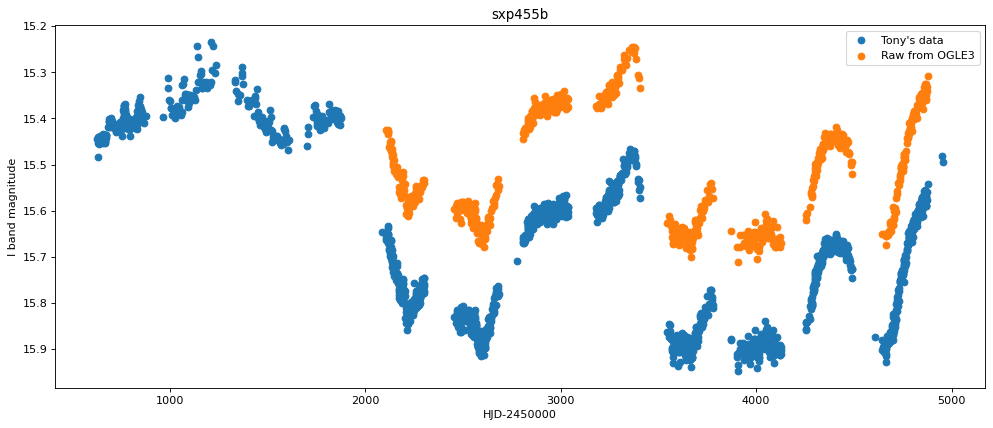

In [51]:
source_index = 40

print(ids_names_bird[source_index])
plt.figure(figsize=(15, 6), dpi=80)
lc_bird = np.loadtxt('../data/ogle_Bird/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
plt.scatter(lc_bird[:,0], lc_bird[:,1], label="Tony's data")


try:
    lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(ids_names_bird[source_index]))
    plt.scatter(lc_ogle3[:,0]-2450000, lc_ogle3[:,1], label="Raw from OGLE3")
except:
    print("no OGLE III data")
try:
    lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(ids_names_bird[source_index]))
    plt.scatter(lc_ogle4[:,0]-2450000, lc_ogle4[:,1], label="Raw from OGLE4")
except:
    print("no OGLE IV data")


plt.title(ids_names_bird[source_index])
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## In the column Bird_ogle3_end_diff above, for each source we can see the most common difference in days (rounded to 2 decimal figures) calculated between the last 100 data points of the OGLE III light curve and the Bird+2012 light curve

## Whenever that is 0.00, we will assume that there is no temporal offset between OGLE data and Bird+2012, and that we can safely concatenate those light curves with OGLE IV without further modification of the Julian dates. We will do that for sources where Bird+2012 data starts substantially earlier than OGLE III (i.e. it includes OGLE II)

## Whenever that is 0.50, we will assume that the Julian dates of the two light curves were modified using sightly different constants, and that we can correct for this simply by adding 0.5 to the time stamps of Bird+2012 light curves

## For any other values, we will need to examine the light curves individually, and resort to replacing Bird+2012 data with OGLE III data in cases where the difference could not be corrected

## Sources where the difference is not 0.00 or 0.50:
- sxp46.6: Bird+2012 data and OGLE III data span the same period of time, so we can disregard the issue and resort to using OGLE III (NB: the magnitudes of Bird+2012 data seem to follow the trend of OGLE IV much better than the OGLE III data)
- sxp152.1: there is no (unambiguous) OGLE IV data available for this source, so we can simply use Bird+2012 (NB: Since there are SXP152.1A and SXP152.1B in OGLE IV, OGLE III might have looked at unresolved data of two different sources? main trends of light curves A and B are very similar, suggesting that it is the same source)
- sxp342: Bird+2012 data and OGLE III data span the same period of time, so we can disregard the issue and resort to using OGLE III
- sxp455a and sxp455b: there is no (unambiguous) OGLE IV data available for these sources, however SXP455 seems to show a very similar pattern of variability. This source could be of great interest, and we might need to look into concatenating those in the future (Bird+2012 contains OGLE II, with what looks like orbital variability). The large difference values could be caused by a gap towards the end of BIRD+2012 light curve, which seems to contain a few more recent data points than OGLE III
- For sources which have no OGLE III data available, we cannot check whether the temporal offset is present, so we will need to either analyse the Bird+2012 and OGLE IV separately, or concatenate them in spite of the possible issue

# The script below creates files of concatenated light curves, following the rules outlined above

In [79]:
lc_bird

array([[2.45208692e+06, 1.51800000e+01, 3.00000000e-03, 5.28000000e+00,
        8.23000000e+02],
       [2.45210691e+06, 1.51630000e+01, 3.00000000e-03, 5.80000000e+00,
        6.35000000e+02],
       [2.45211484e+06, 1.51870000e+01, 3.00000000e-03, 7.12000000e+00,
        6.69000000e+02],
       ...,
       [2.45484658e+06, 1.56100000e+01, 4.00000000e-03, 4.80000000e+00,
        5.65000000e+02],
       [2.45485061e+06, 1.56040000e+01, 4.00000000e-03, 6.24000000e+00,
        5.91000000e+02],
       [2.45486855e+06, 1.55510000e+01, 4.00000000e-03, 5.14000000e+00,
        7.04000000e+02]])

In [112]:
# names_ids_bird = {v: k for k, v in ids_names_bird.items()}

for source_index, values in ogle_dates.iterrows():
    source_name = ids_names_bird[source_index]
    if ~np.isnan(values.ogle3_start): # only consider concatenation if OGLE III is available
        if (values.Bird_start + 10 < values.ogle3_start) and ~np.isnan(values.ogle4_start): # if Bird+2012 light curve starts significantly earlier and if OGLE IV is available
            lc_bird = np.loadtxt('../data/ogle_Bird/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
            # make corrections to time if required
            if values.Bird_ogle3_end_diff == 0.5:
                lc_bird[:,0] += 0.5
            elif values.Bird_ogle3_end_diff != 0.0:
                lc_bird = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name), usecols=(0,1,2))
                lc_bird[:,0] -= 2450000
                
            lc_bird_df = pd.DataFrame(lc_bird)
            last_month_bird = lc_bird_df[lc_bird_df[0] > lc_bird_df[0].iloc[-1]-30] # data within the last 30 days of the light curve
                
            lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name), usecols=(0,1,2))
            lc_ogle4[:,0] -= 2450000
            
            lc_ogle4_df = pd.DataFrame(lc_ogle4)
            first_month_ogle4 = lc_ogle4_df[lc_ogle4_df[0] < lc_ogle4_df[0].iloc[0]+30] # data within the first 30 days of the light curve
            
            lc_bird[:,1] -= last_month_bird[1].median() - first_month_ogle4[1].median()
            
            lc_merged = np.vstack((lc_bird, lc_ogle4))
            np.savetxt("../data/Bird_ogle_merged/{}.csv".format(source_name), lc_merged, delimiter=",")
        elif ~np.isnan(values.ogle4_start): #merge ogle3 with ogle4
            lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name), usecols=(0,1,2))
            lc_ogle3[:,0] -= 2450000
            
            lc_ogle3_df = pd.DataFrame(lc_ogle3)
            last_month_ogle3 = lc_ogle3_df[lc_ogle3_df[0] > lc_ogle3_df[0].iloc[-1]-30] # data within the last 30 days of the light curve
            
            lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name), usecols=(0,1,2))
            lc_ogle4[:,0] -= 2450000
            
            lc_ogle4_df = pd.DataFrame(lc_ogle4)
            first_month_ogle4 = lc_ogle4_df[lc_ogle4_df[0] < lc_ogle4_df[0].iloc[0]+30] # data within the first 30 days of the light curve
            
            lc_ogle3[:,1] -= last_month_ogle3[1].median() - first_month_ogle4[1].median()
            
            lc_merged = np.vstack((lc_ogle3, lc_ogle4))
            np.savetxt("../data/Bird_ogle_merged/{}.csv".format(source_name), lc_merged, delimiter=",")

<Figure size 1200x480 with 0 Axes>

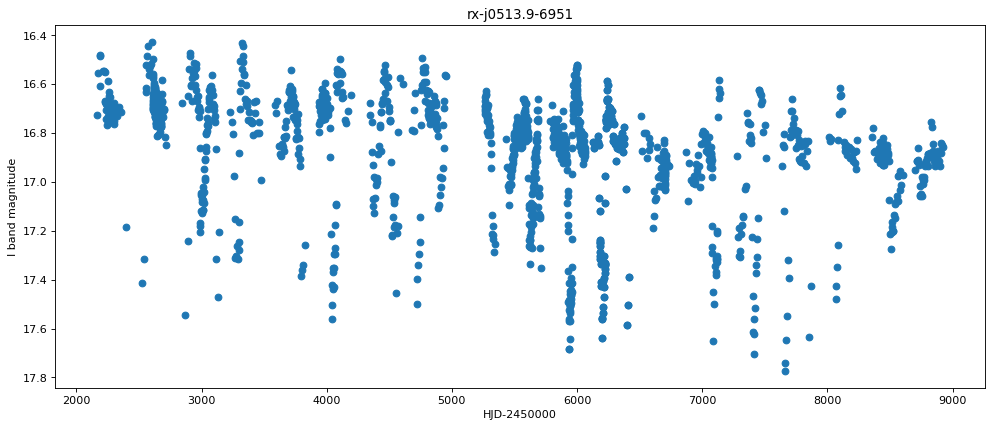

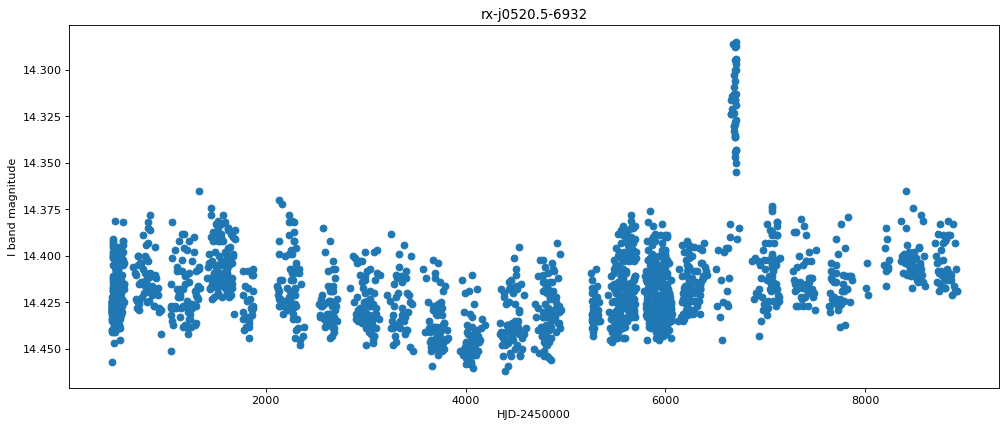

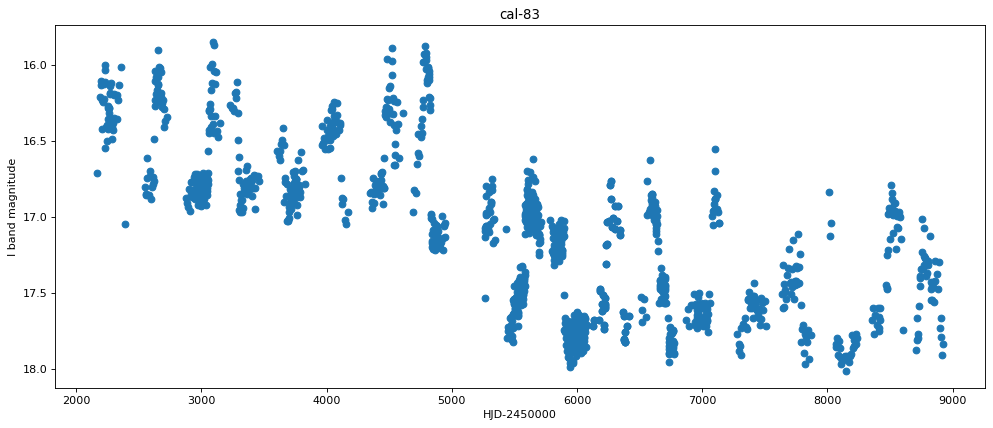

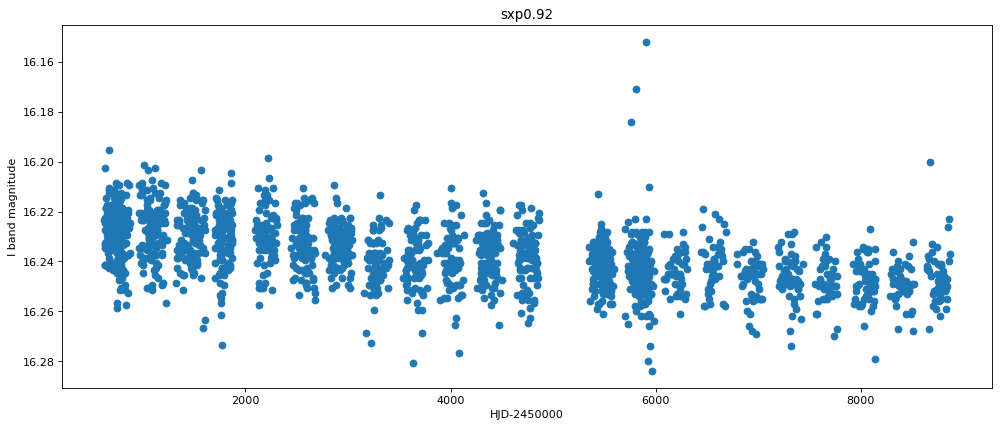

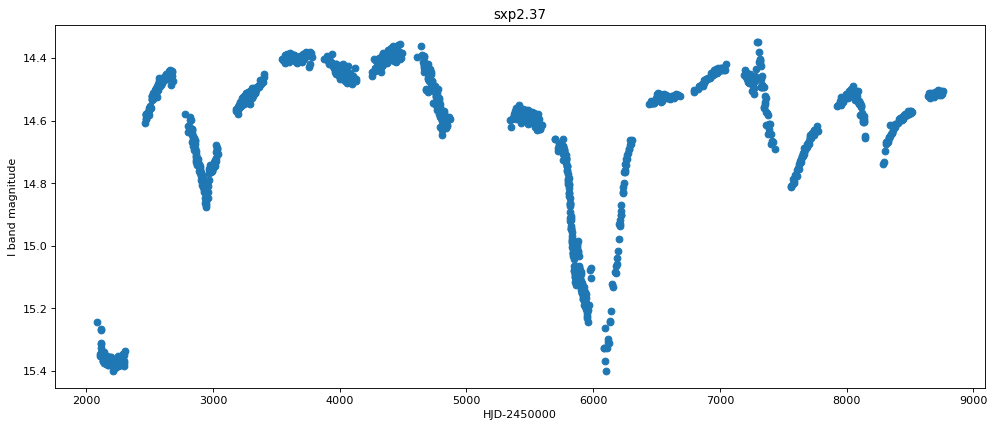

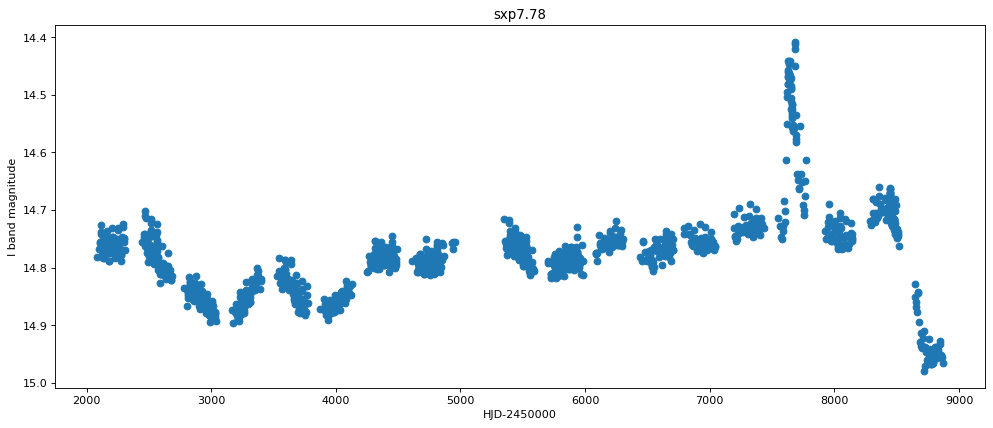

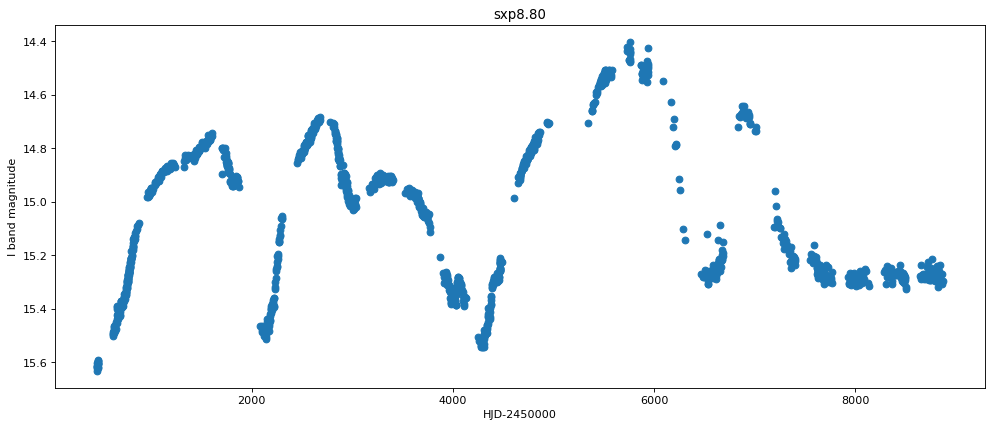

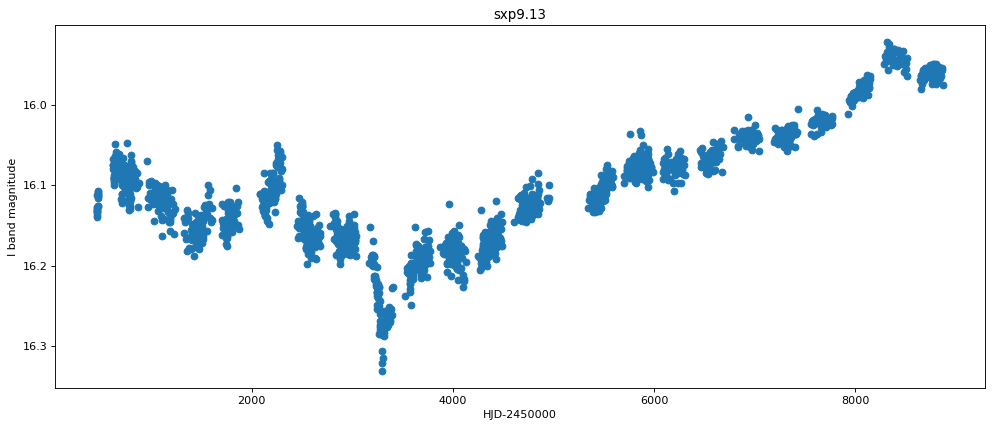

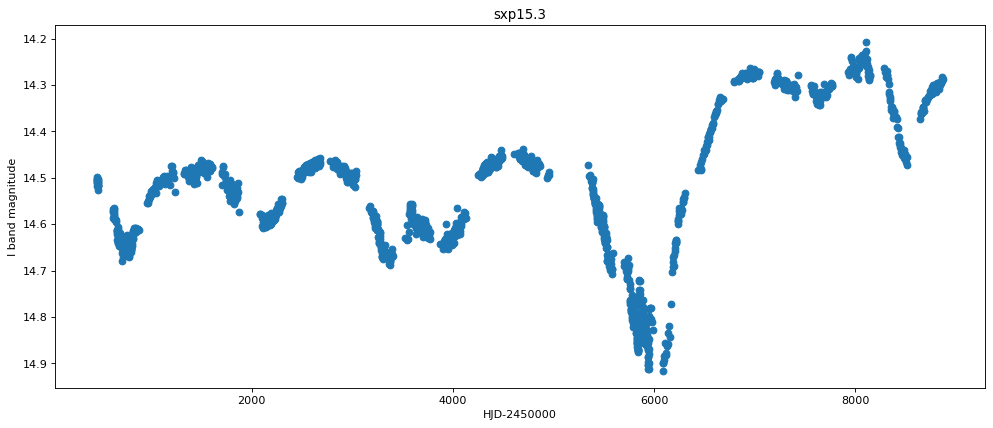

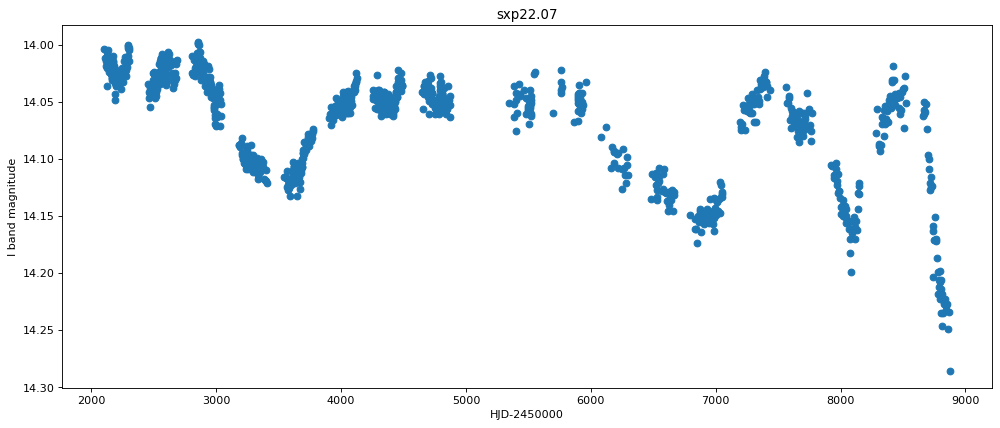

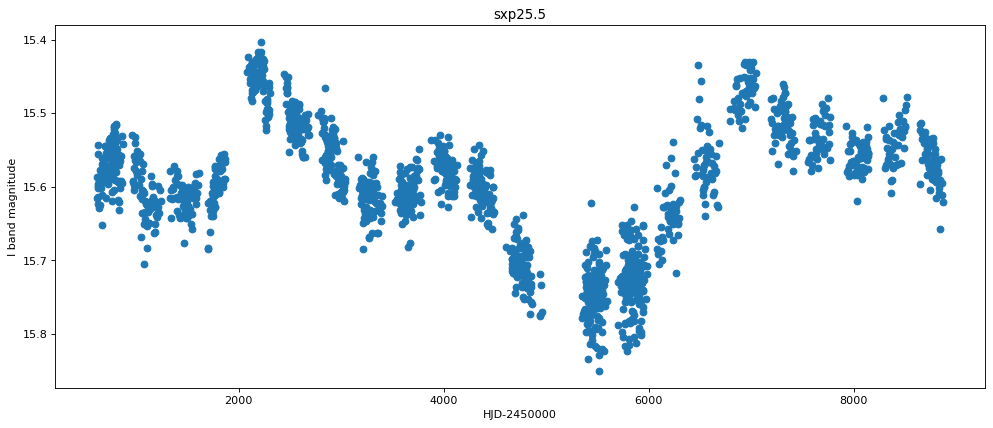

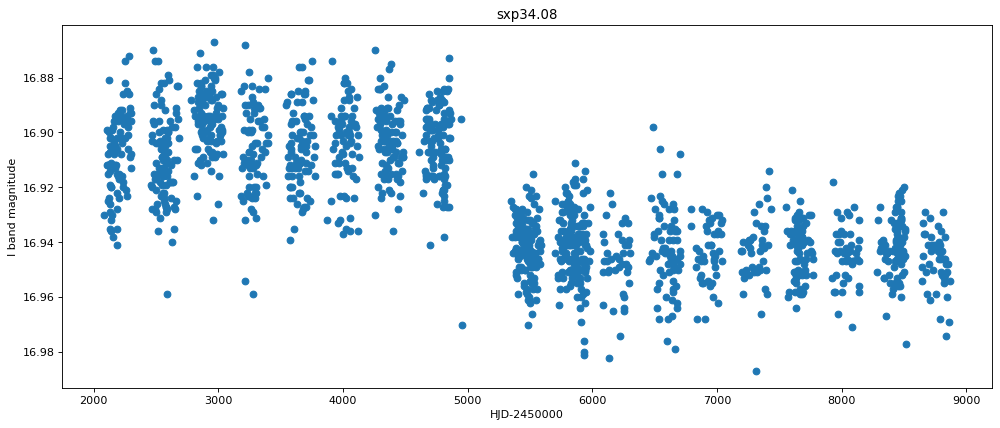

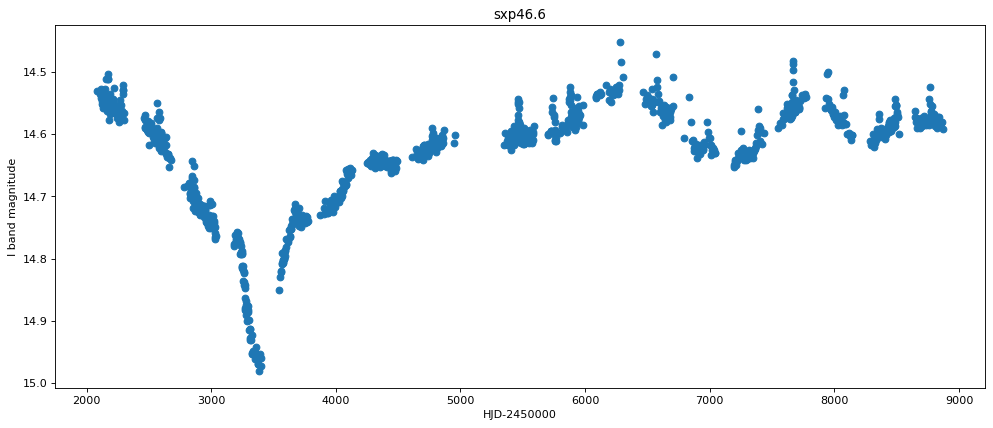

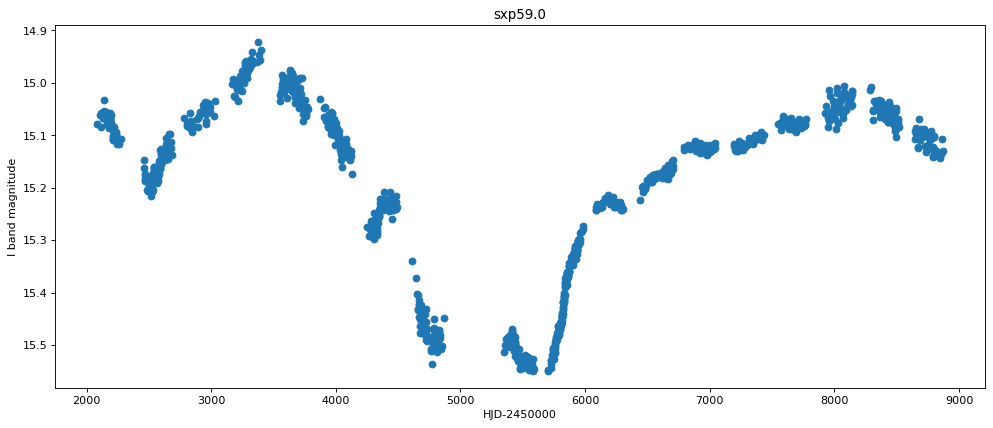

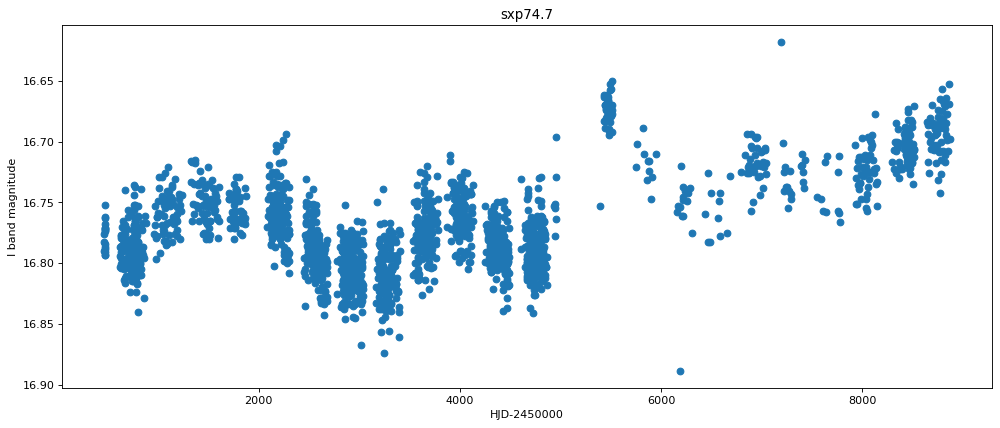

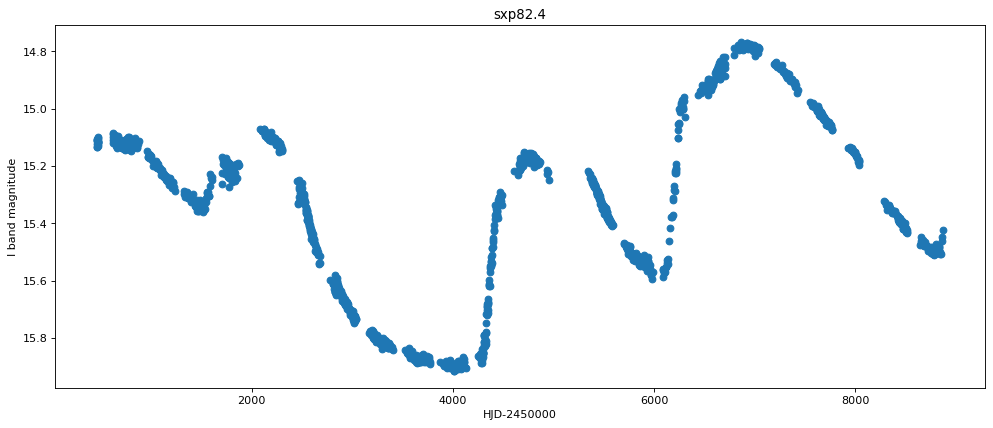

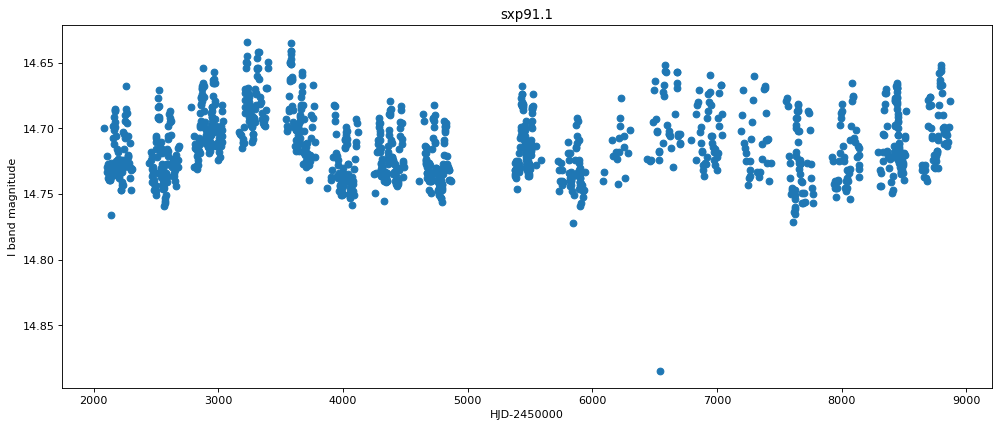

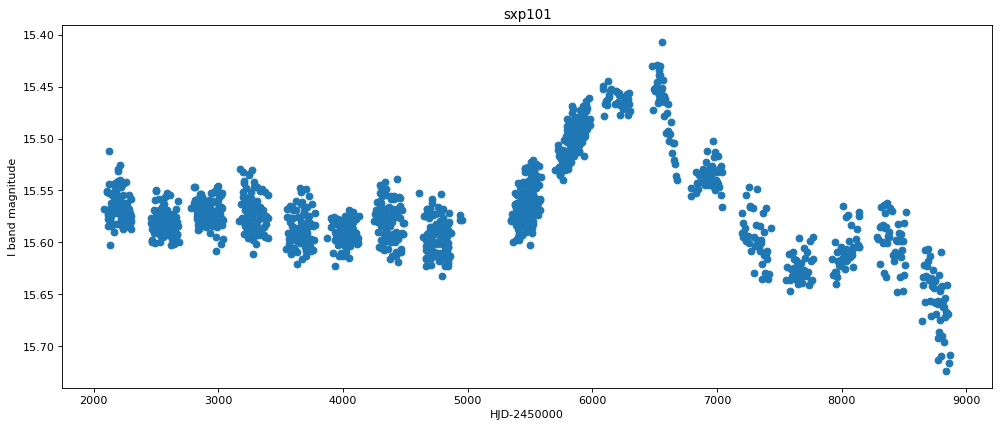

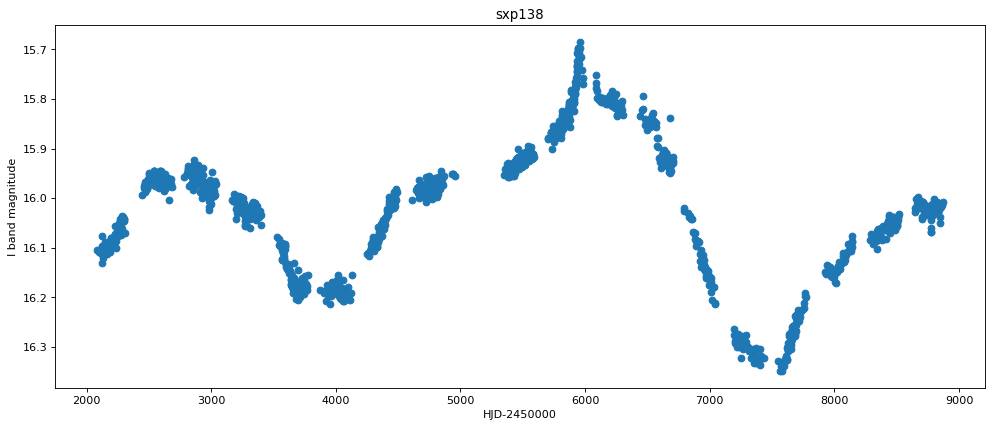

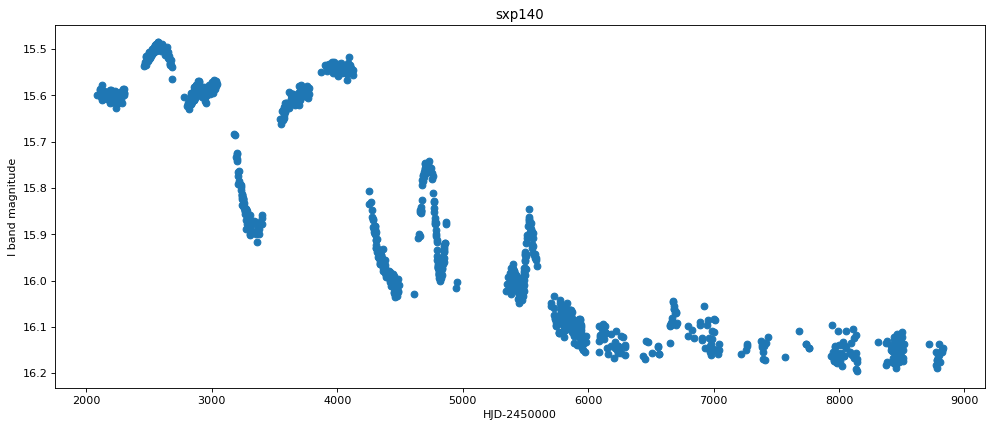

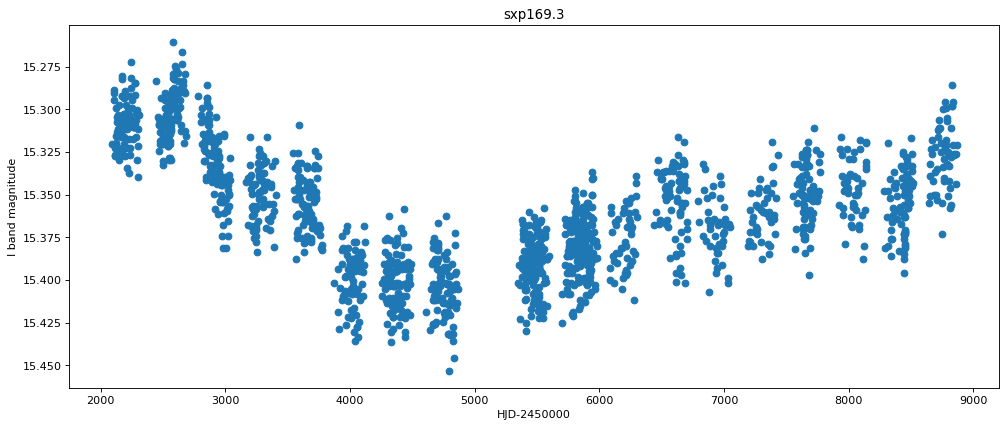

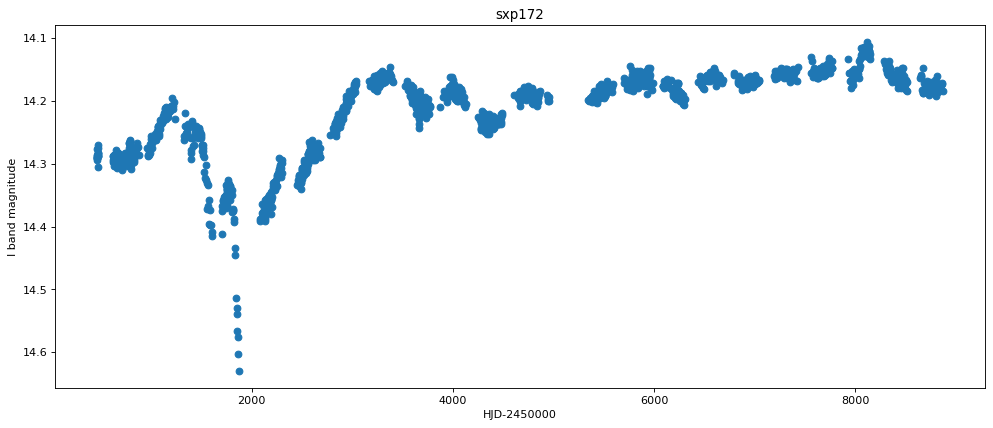

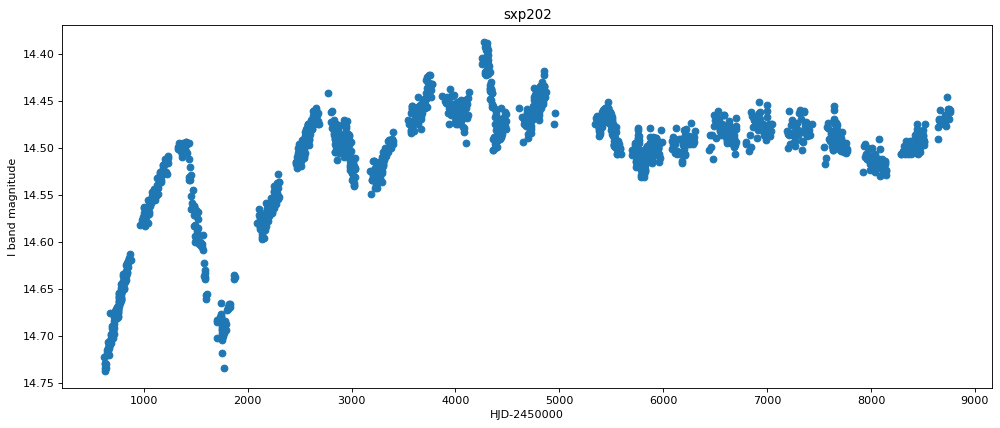

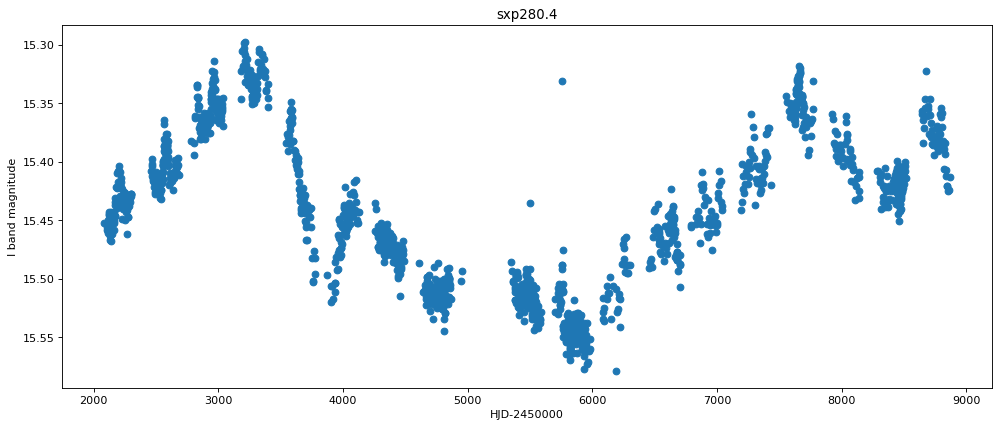

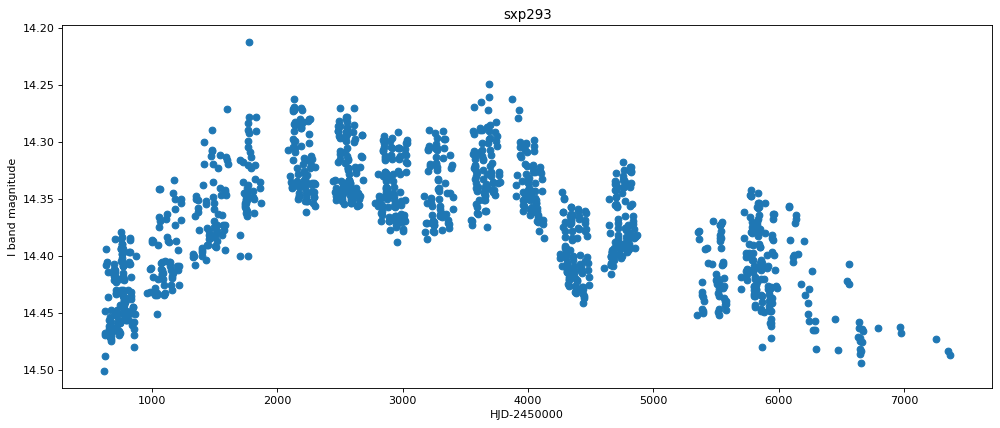

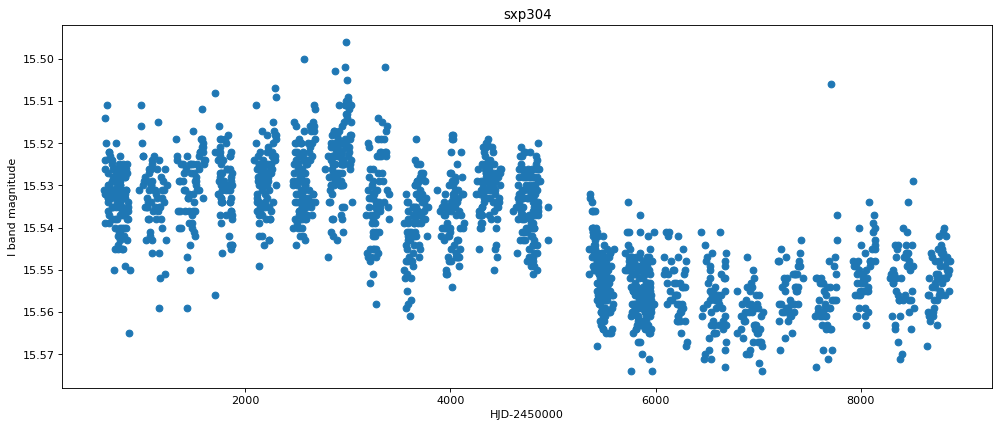

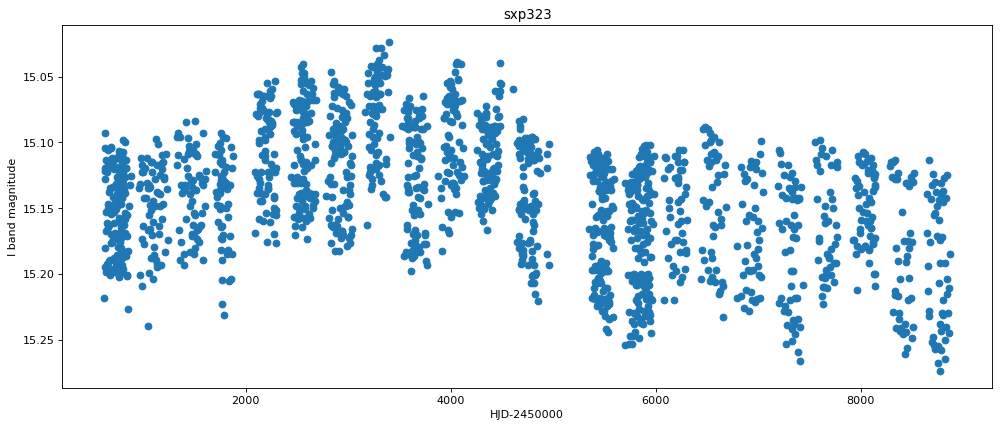

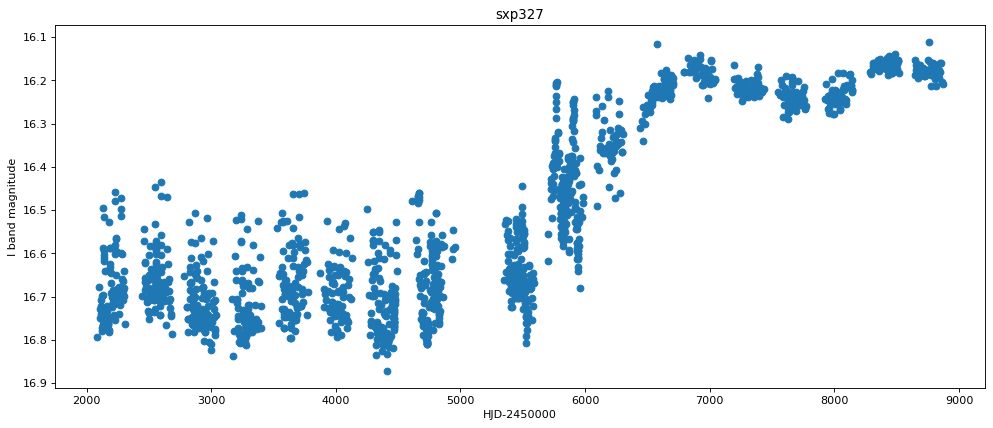

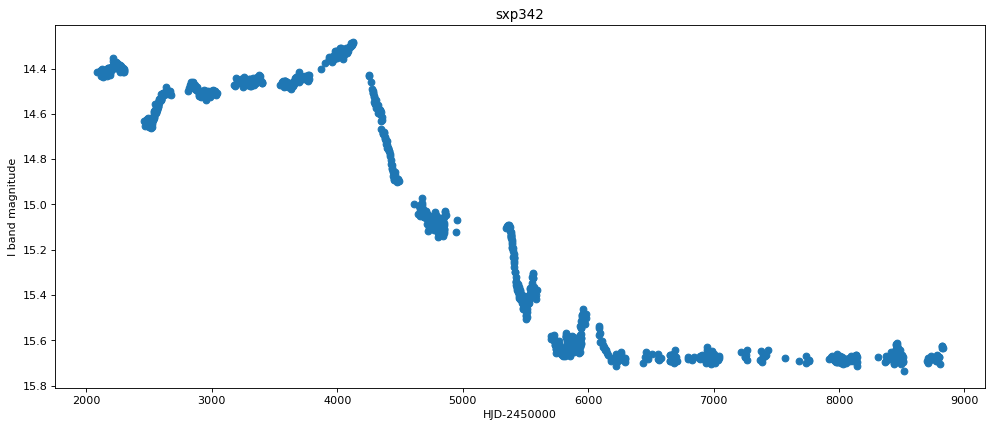

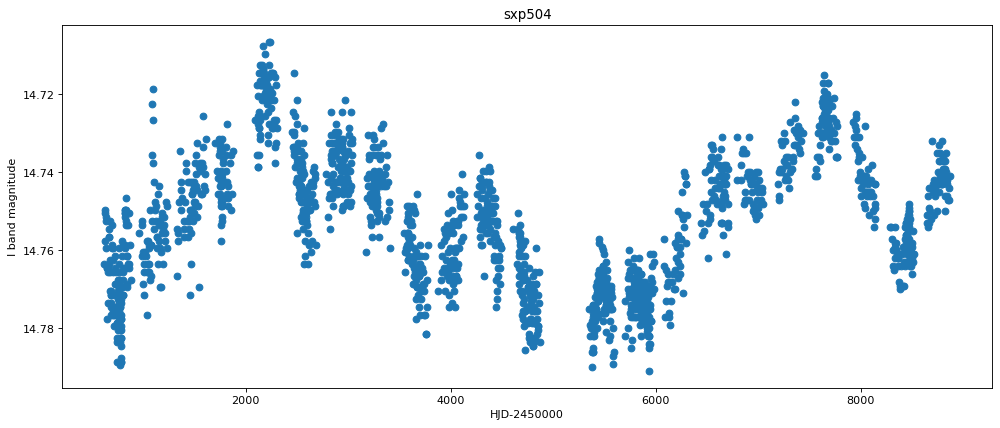

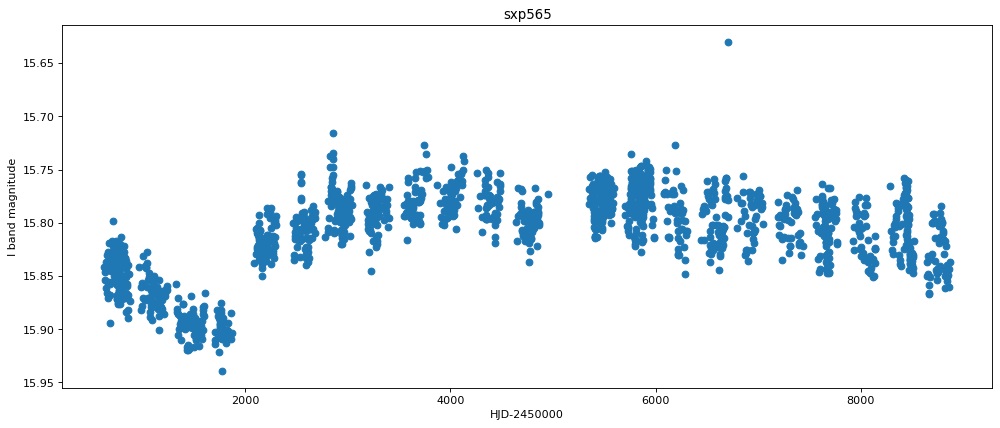

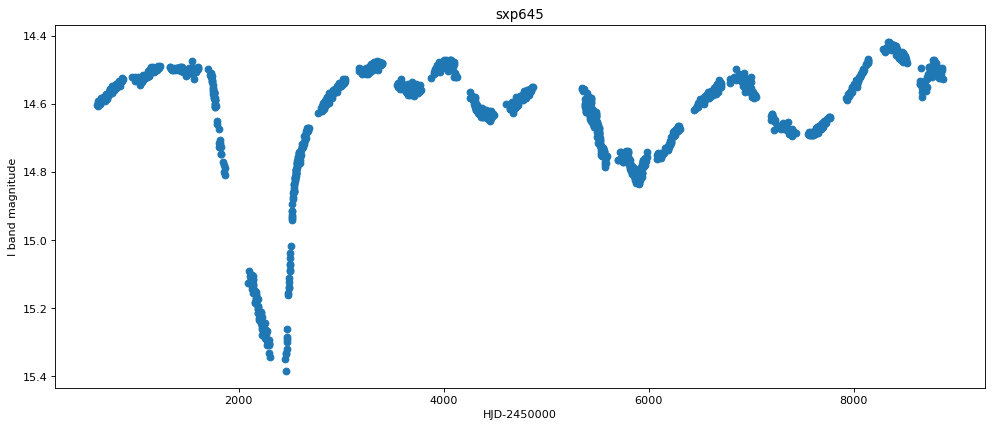

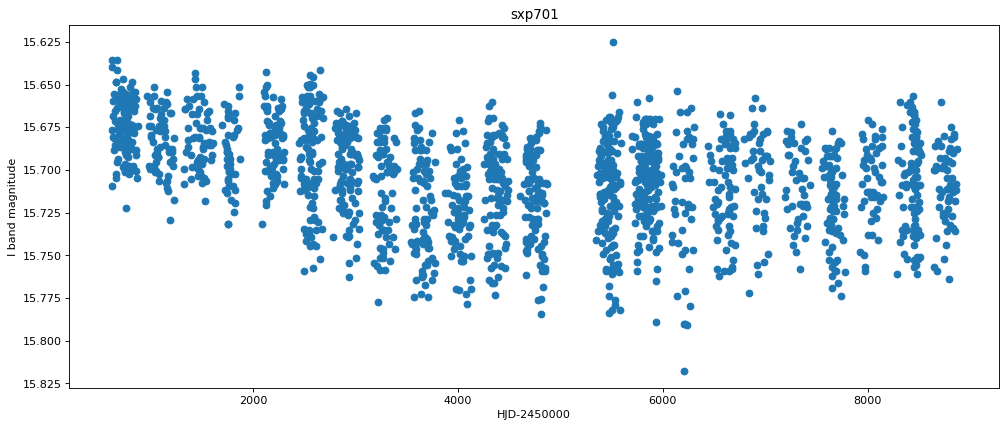

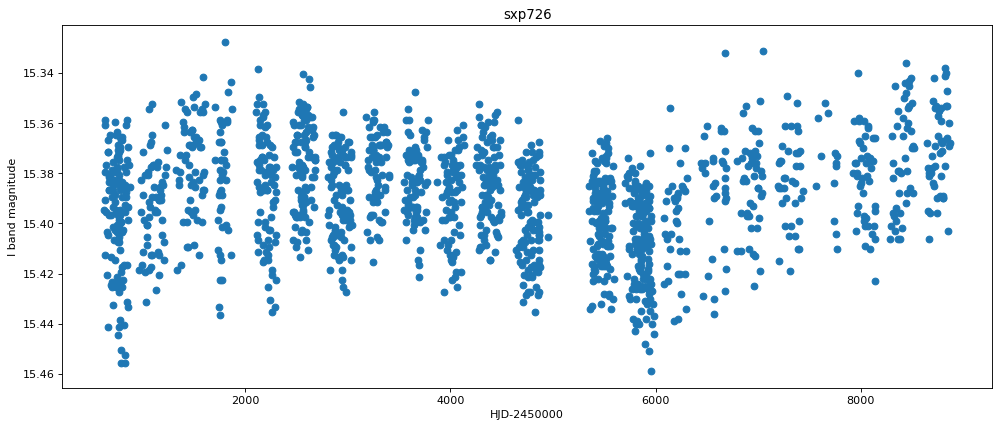

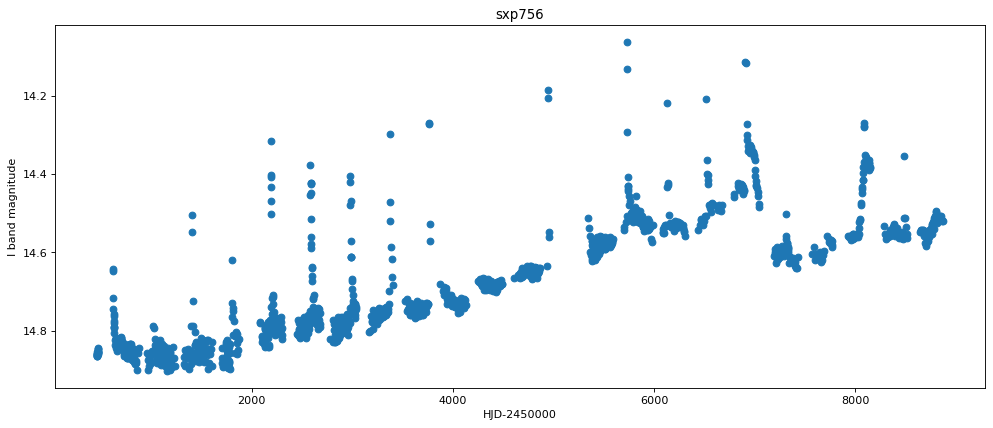

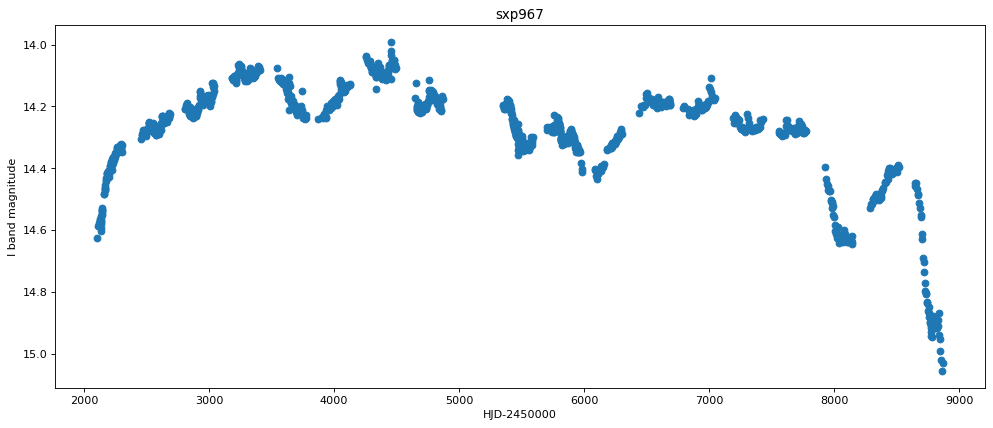

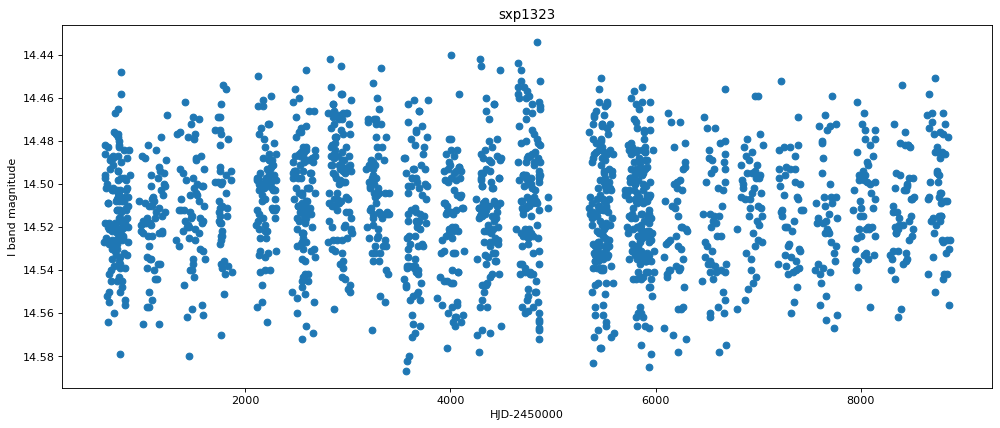

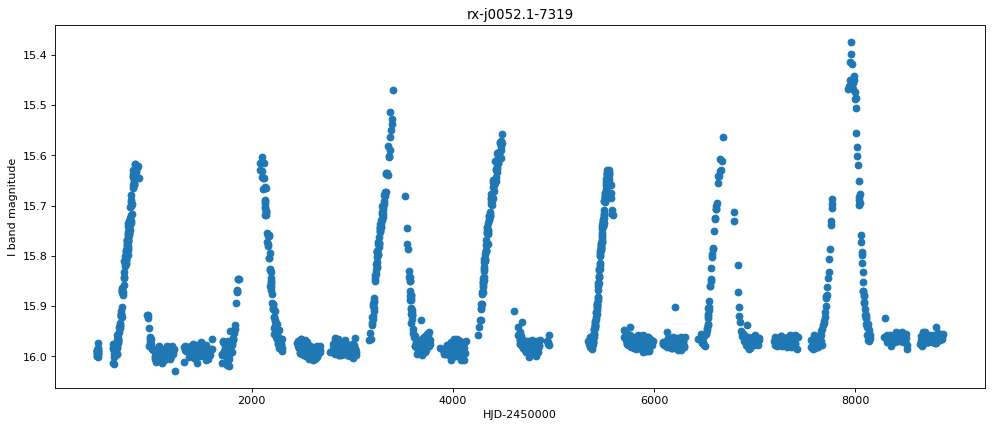

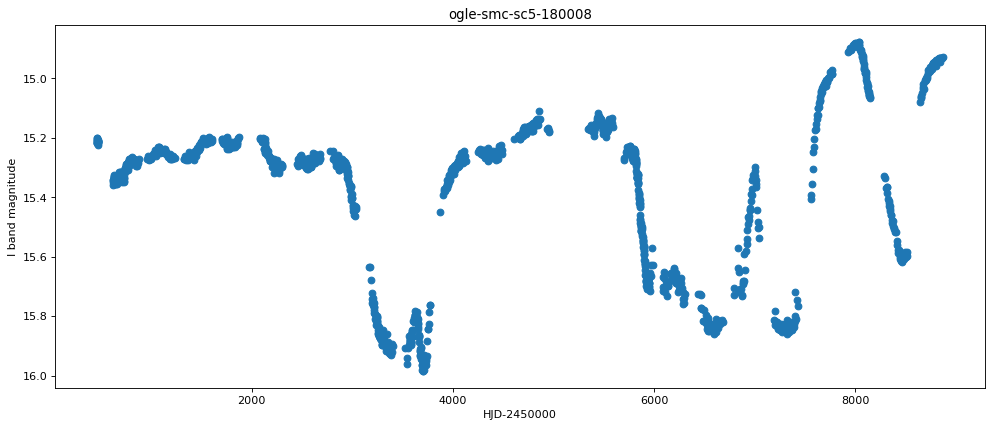

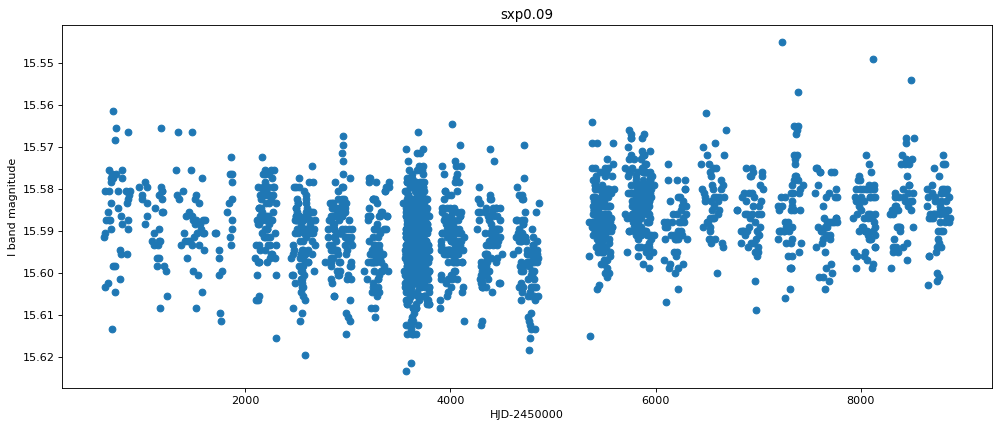

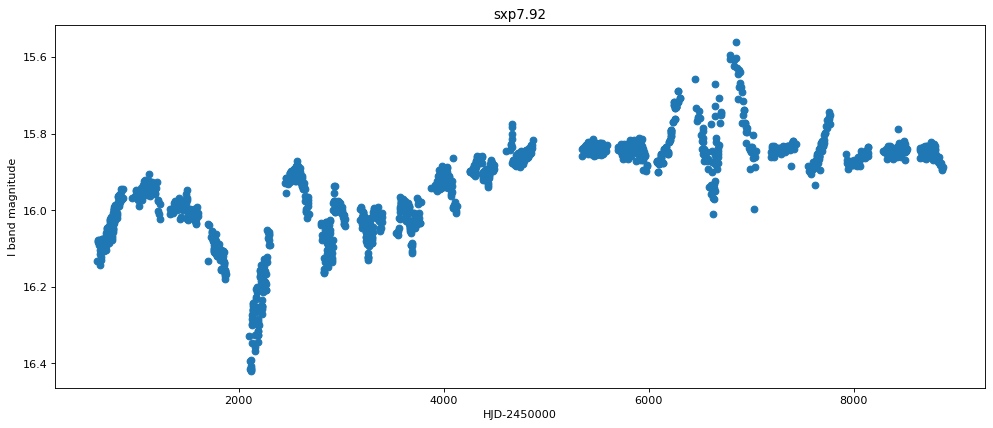

In [113]:
# visualise merged light curves
plt.figure(figsize=(15, 6), dpi=80)
for root, dirnames, filenames in os.walk("../data/Bird_ogle_merged/"):
    for filename in filenames:
        lc_path = os.path.join(root, filename)
        lc = np.loadtxt(lc_path, delimiter=",")
        plt.figure(figsize=(15, 6), dpi=80)
        plt.scatter(lc[:,0], lc[:,1])
        plt.title(filename[:-4])
        plt.xlabel("HJD-2450000")
        plt.ylabel("I band magnitude")
        plt.gca().invert_yaxis()
        plt.show()